In [1]:
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img, load_img
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

2024-02-23 14:34:55.944210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 14:34:55.944328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 14:34:56.069312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_path = "/kaggle/input/bacteria-figshare/"
# tmp_data_path = "/content/tmp_data/"
root_dir = '/kaggle/working/data/'

In [3]:
INPUT_SIZE = 75
input_shape = (INPUT_SIZE, INPUT_SIZE, 3)  # Assuming color images (3 channels)
num_classes = 24
batch_size = 32

In [4]:
# def pad_array(input_array, target_shape=(224, 224, 3)):
#     # Get the current shape of the input array
#     current_shape = input_array.shape

#     # Calculate the difference between the target shape and current shape
#     pad_width = [(0, max(0, target_shape[i] - current_shape[i])) for i in range(len(target_shape))]

#     # Pad the array using numpy.pad
#     padded_array = np.pad(input_array, pad_width, mode='constant', constant_values=0)

#     return padded_array

In [5]:
# ??this code returns the image resizing to our desired size and 
def pad_array(input_array, target_shape=(224, 224, 3)):
    # Get the current shape of the input array
    return cv2.resize(input_array,(75,75))

In [6]:
def make_augmented_images(path,times,final_path):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    img = load_img(path)
    x = img_to_array(img)  
    x = x.reshape((1,) + x.shape) 

    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=final_path, save_prefix='augmented', save_format='jpeg'):
        i += 1
        if i > times:
            break  # otherwise the generator would loop indefinitely

In [7]:
for annotated_file in glob.glob(os.path.join('/kaggle/input/bacteria-figshare/annot_YOLO/', '*.txt')):
    with open(annotated_file) as f:
        # for getting colonies coordinates
        if os.path.exists(f'/kaggle/working/data2/{annotated_file[-14:-10]}') == False:
            os.makedirs(f'/kaggle/working/data2/{annotated_file[-14:-10]}')
        tmp_list = []
        for text in f:
            second_tmp = []
            for i, coordinates in enumerate(text.split(' ')):
                if i == 4:
                    second_tmp.append(coordinates.strip())
                else:
                    second_tmp.append(coordinates)
            tmp_list.append(second_tmp)

        # For image croping
        image = cv2.imread(f'{image_path}{annotated_file[-14:-4]}.jpg')
        boxes = tmp_list

        shift = 0.01

        for i, box in enumerate(boxes):
            x_min = float(box[1]) - shift
            y_min = float(box[2]) - shift
            width = float(box[3])
            height = float(box[4])

            x_max = x_min + width
            y_max = y_min + height

            cropped = image[int(y_min*image.shape[0]):int(y_max*image.shape[0]),
                          int(x_min*image.shape[1]):int(x_max*image.shape[1])]
            try:
                cropped = pad_array(cropped, target_shape=(INPUT_SIZE, INPUT_SIZE, 3))
            except:
                continue
            save_path = f'/kaggle/working/data2/{annotated_file[-14:-10]}/'+str(i)+f'_{annotated_file[-14:-4]}.jpg'
            final_path = f'/kaggle/working/data2/{annotated_file[-14:-10]}/'
            if(cropped.size==0):
                print("Locha: ", annotated_file)
            else:
                cv2.imwrite(save_path, cropped)
            make_augmented_images(save_path,1,final_path)

In [8]:
root_dir = '/kaggle/working/data2/'
datagen = ImageDataGenerator(
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    root_dir,
    target_size=(INPUT_SIZE, INPUT_SIZE),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)


Found 103946 images belonging to 24 classes.
Found 25974 images belonging to 24 classes.


In [16]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall

batch_size = 32
base_model = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='sigmoid'))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='sigmoid'))
model.add(Dropout(0.5))  # Dropout layer for regularization
model.add(Dense(num_classes, activation='softmax'))



# # Compile the model
model.compile(optimizer=Nadam(), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)

# # Train the model
epochs = 20
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=epochs, 
    validation_data=val_generator,
    validation_steps=val_generator.samples // 32,
    callbacks = [reduce_lr]
)

16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/20


2024-02-23 15:41:58.025109: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


3248/3248 [==============================] - 318s 79ms/step - loss: 0.7006 - accuracy: 0.7920 - precision_2: 0.8589 - recall_2: 0.7418 - val_loss: 0.2991 - val_accuracy: 0.9044 - val_precision_2: 0.9270 - val_recall_2: 0.8896 - lr: 0.0010
Epoch 2/20
3248/3248 [==============================] - 255s 79ms/step - loss: 0.3781 - accuracy: 0.8847 - precision_2: 0.9098 - recall_2: 0.8637 - val_loss: 0.2516 - val_accuracy: 0.9226 - val_precision_2: 0.9406 - val_recall_2: 0.9046 - lr: 0.0010
Epoch 3/20
3248/3248 [==============================] - 256s 79ms/step - loss: 0.3154 - accuracy: 0.9044 - precision_2: 0.9250 - recall_2: 0.8886 - val_loss: 0.2014 - val_accuracy: 0.9366 - val_precision_2: 0.9482 - val_recall_2: 0.9286 - lr: 0.0010
Epoch 4/20
3248/3248 [==============================] - 262s 81ms/step - loss: 0.2772 - accuracy: 0.9154 - precision_2: 0.9327 - recall_2: 0.9014 - val_loss: 0.1820 - val_accuracy: 0.9428 - val_precision_2: 0.9507 - val_recall_2: 0.9355 - lr: 0.0010
Epoch 5/20


In [20]:
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, top_k_accuracy_score, confusion_matrix
import numpy as np

# Assuming you already have the trained model and validation data generator (val_generator) from the previous code

# Evaluate the model on the validation set
predictions = model.predict(val_generator)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert true labels to class labels
true_labels = val_generator.classes

# Calculate top-3 and top-4 accuracy
top3_accuracy = top_k_accuracy_score(true_labels, predictions, k=3)
top5_accuracy = top_k_accuracy_score(true_labels, predictions, k=5)
 
# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate recall, F1 score, and classification report
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')
conf_matrix = confusion_matrix(true_labels, predicted_labels)
classification_rep = classification_report(true_labels, predicted_labels)

# Print the metrics
print(f'Top-3 Accuracy: {top3_accuracy * 100:.2f}%')
print(f'Top-5 Accuracy: {top5_accuracy * 100:.2f}%')
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)


812/812 [==============================] - 13s 16ms/step
Top-3 Accuracy: 99.84%
Top-5 Accuracy: 99.92%
Overall Accuracy: 98.39%
Recall: 98.39%
F1 Score: 98.39%
[[ 222    0    3    0    1    0    0    1    0    0    0    0    0    0
     0    0    0    0    0    0    0    4    0    0]
 [   0  828    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    1    0]
 [   0    0  170    0    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    0    0  178    1    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0    2    0    0 1940    0    0    0    0    1    0    0    1    0
     0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    1 2359    1    0    0   12    0    0    0    0
     0    0    0    0    7    0    1   10   35    0]
 [   0    0    0    0    0    0  583    0   16    1    0    0    0    0
     0    3    0  

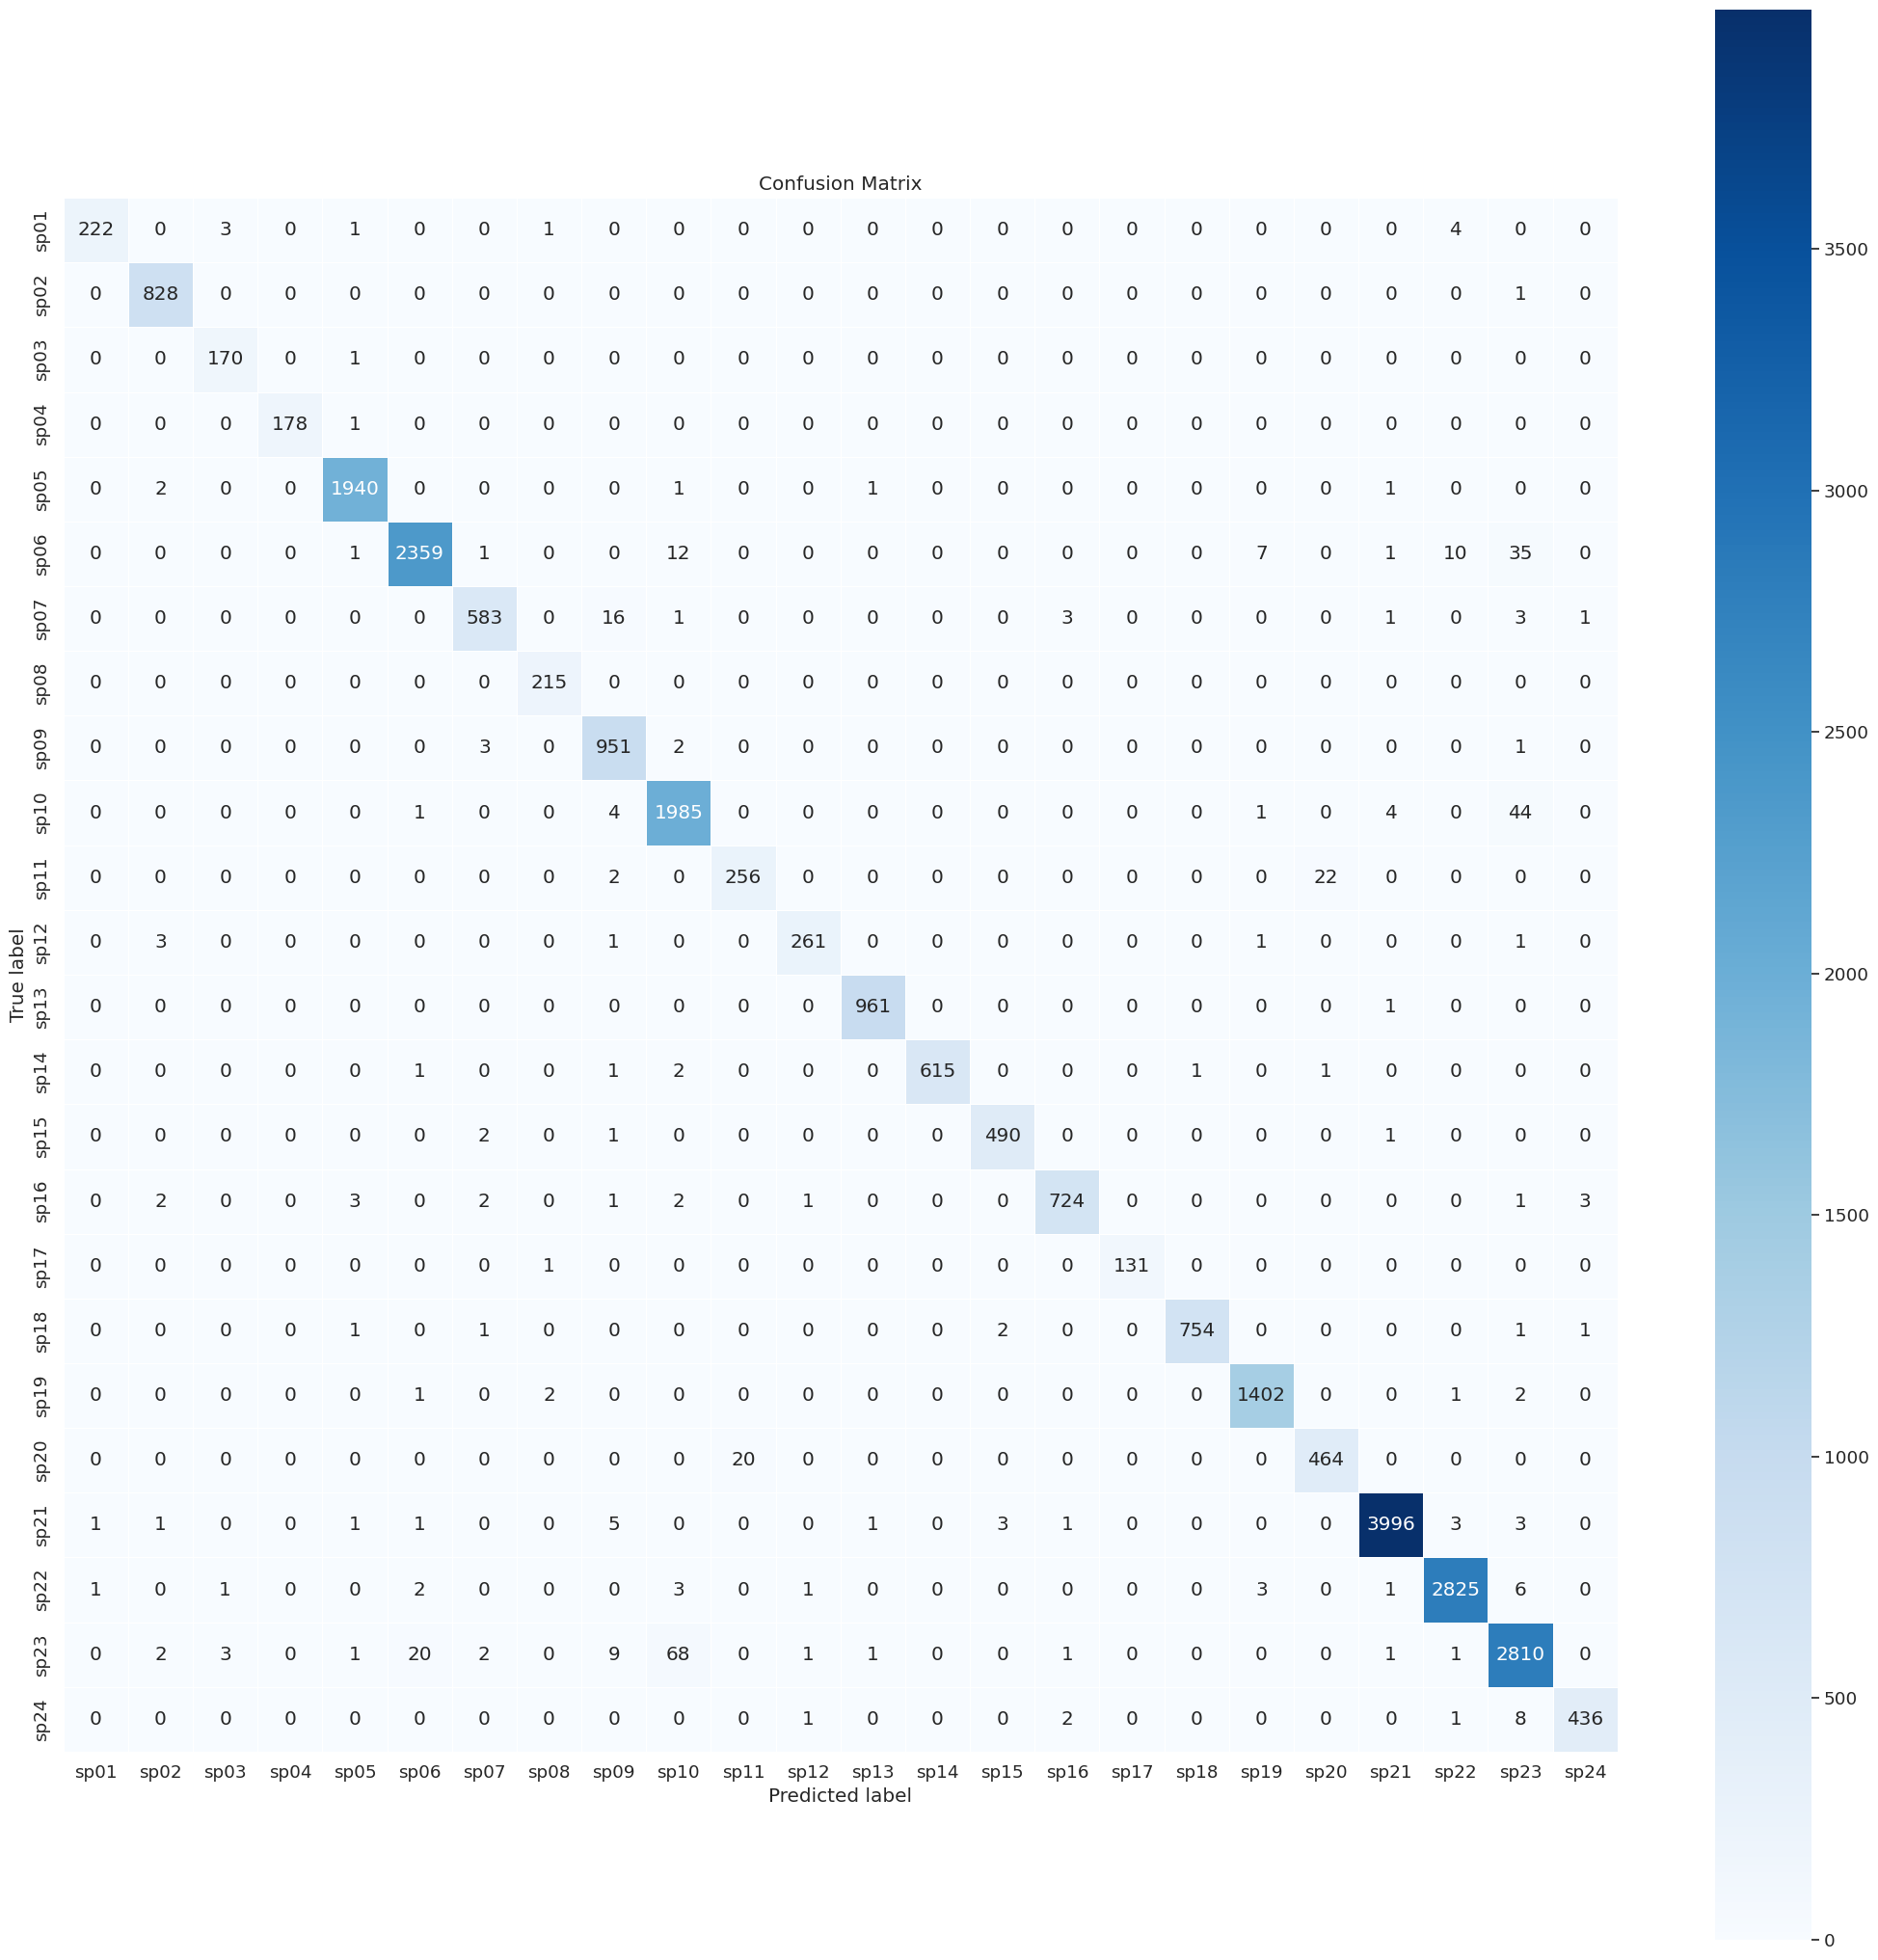

In [21]:
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Plot the confusion matrix for multi-class classification.

    Parameters:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        classes (list): List of class names.
        title (str): Title of the plot.
        cmap (matplotlib.colors.Colormap): Colormap for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(len(classes)+2, len(classes)+2))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, linewidths=.5, square=True,
                xticklabels=classes, yticklabels=classes)

    plt.title(title)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

# Example usage:
# Replace y_true and y_pred with your actual and predicted labels

plot_confusion_matrix(true_labels, predicted_labels, classes=["sp01", "sp02", "sp03", "sp04", "sp05", "sp06", "sp07", "sp08", "sp09", "sp10", "sp11", "sp12", "sp13", "sp14", "sp15", "sp16", "sp17", "sp18", "sp19", "sp20", "sp21", "sp22", "sp23","sp24"])


In [22]:
from tensorflow.keras.preprocessing import image

# Preprocess the image
img_path = '/kaggle/working/data2/sp11/89_sp11_img04.jpg'
img = image.load_img(img_path, target_size=(75,75,3))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

model.predict(img_array).argmax()+1

1/1 [==============================] - 0s 26ms/step


11